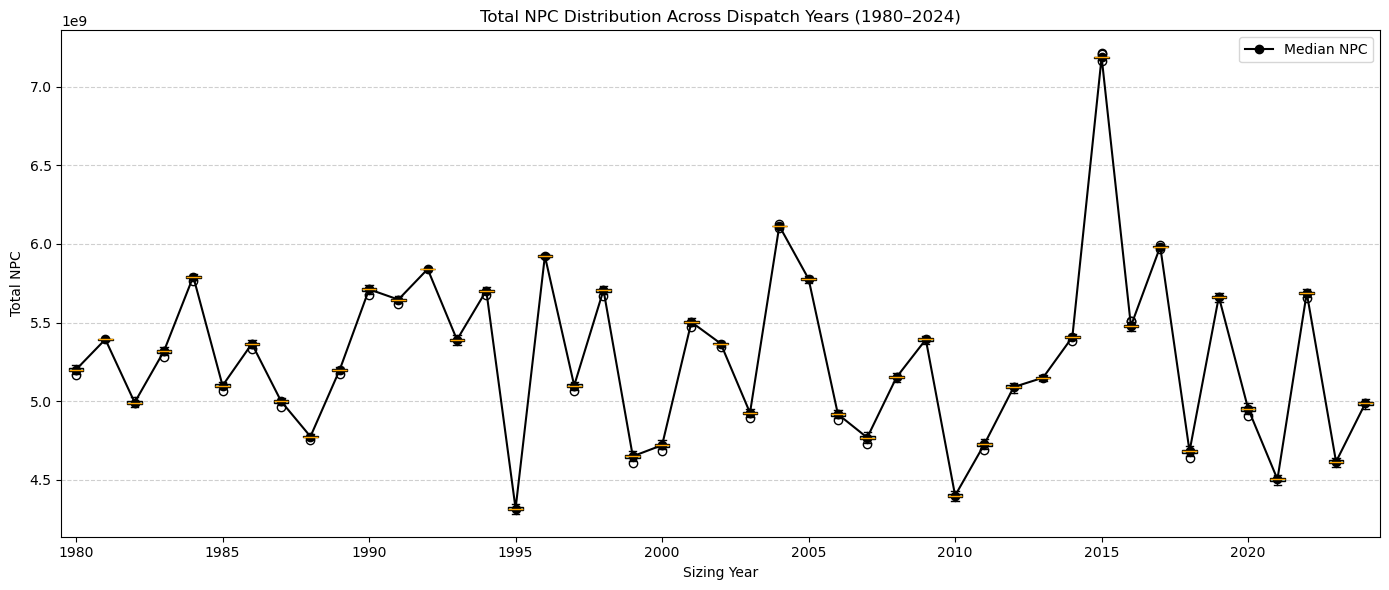

[4986639519.839056, 4614461693.158353, 5688302340.098418, 4502892738.189976, 4951780548.059878, 5664092704.933911, 4681117782.043994, 5982424961.908889, 5477859325.424044, 7186876214.54826, 5407302872.810122, 5148959904.563633, 5089737517.731569, 4726756762.509656, 4399421968.614428, 5392244345.924594, 5151822550.927861, 4767979176.5536375, 4916818584.223863, 5776796901.714947, 6114219292.389325, 4925602623.468904, 5366181605.567654, 5502724525.425607, 4720097495.634021, 4649237149.569714, 5706483379.977115, 5099161866.569866, 5922935043.621852, 4316764571.269512, 5702803574.488908, 5390318810.558431, 5839870814.221114, 5645858166.694203, 5711324750.423129, 5200338373.810914, 4774677797.868078, 4998410962.903941, 5365112741.7171335, 5098502258.236989, 5792373438.411675, 5318117531.581888, 4991285876.84276, 5393142270.781822, 5200599476.275006]
5272454062.490859


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Folder naming pattern ===
base_folder = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc"
folder_pattern = lambda year: base_folder if year == 2024 else base_folder + str(year)

years = list(range(2024, 1979, -1))
npc_data = []
npc_medians = []

for sizing_year in years:
    folder = folder_pattern(sizing_year)
    file_path = os.path.join(folder, "capacity_and_costs_by_year.csv")
    
    try:
        df = pd.read_csv(file_path)
        # DO NOT filter by year — grab all available years of dispatch
        npcs = df['Total_NPC'].dropna().tolist()
        npc_data.append(npcs)
        npc_medians.append(np.median(npcs))
    except Exception as e:
        print(f"Failed for {sizing_year}: {e}")
        npc_data.append([])
        npc_medians.append(np.nan)

# === Plot ===
plt.figure(figsize=(14, 6))

plt.boxplot(npc_data, patch_artist=True,
            boxprops=dict(facecolor='skyblue'),
            medianprops=dict(color='orange'),
            showfliers=True)

plt.plot(range(1, len(npc_medians)+1), npc_medians, color='black', linestyle='-', marker='o', label='Median NPC')

tick_indices = [i+1 for i, y in enumerate(years) if y % 5 == 0]
tick_labels = [y for y in years if y % 5 == 0]

plt.xticks(ticks=tick_indices, labels=tick_labels)
plt.gca().invert_xaxis()

plt.title("Total NPC Distribution Across Dispatch Years (1980–2024)")
plt.ylabel("Total NPC")
plt.xlabel("Sizing Year")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(npc_medians)

average_cost=np.mean(npc_medians)
print(average_cost)


2024: Avg NPC = 4.99e+09, Avg Uptime = 99.80%
2023: Avg NPC = 4.61e+09, Avg Uptime = 99.29%
2022: Avg NPC = 5.69e+09, Avg Uptime = 99.96%
2021: Avg NPC = 4.50e+09, Avg Uptime = 99.43%
2020: Avg NPC = 4.95e+09, Avg Uptime = 99.77%
2019: Avg NPC = 5.66e+09, Avg Uptime = 99.96%
2018: Avg NPC = 4.68e+09, Avg Uptime = 99.64%
2017: Avg NPC = 5.98e+09, Avg Uptime = 99.85%
2016: Avg NPC = 5.48e+09, Avg Uptime = 99.79%
2015: Avg NPC = 7.19e+09, Avg Uptime = 100.00%
2014: Avg NPC = 5.41e+09, Avg Uptime = 99.88%
2013: Avg NPC = 5.15e+09, Avg Uptime = 99.59%
2012: Avg NPC = 5.09e+09, Avg Uptime = 99.71%
2011: Avg NPC = 4.73e+09, Avg Uptime = 99.65%
2010: Avg NPC = 4.40e+09, Avg Uptime = 99.26%
2009: Avg NPC = 5.39e+09, Avg Uptime = 99.82%
2008: Avg NPC = 5.15e+09, Avg Uptime = 99.48%
2007: Avg NPC = 4.77e+09, Avg Uptime = 99.68%
2006: Avg NPC = 4.92e+09, Avg Uptime = 99.70%
2005: Avg NPC = 5.78e+09, Avg Uptime = 99.96%
2004: Avg NPC = 6.11e+09, Avg Uptime = 99.89%
2003: Avg NPC = 4.93e+09, Avg Upt

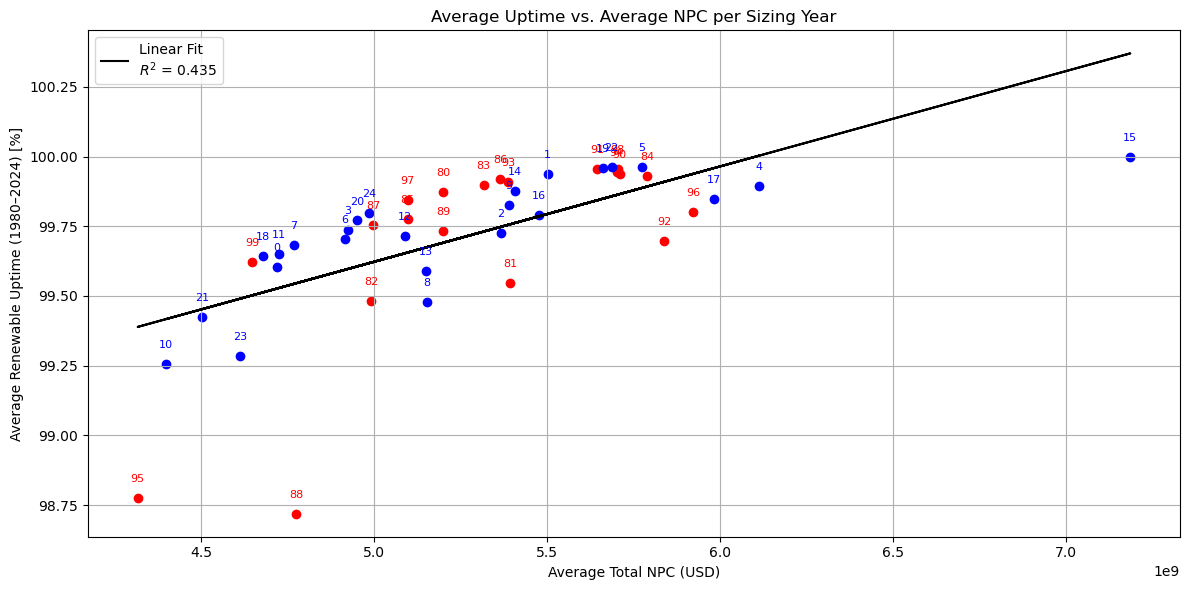

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === Configuration ===
base_path = r"C:\Users\Abdullah"
sizing_years = list(range(2024, 1979, -1))
dispatch_years = list(range(2024, 1979, -1))
folder_pattern = lambda year: (
    os.path.join(base_path, "dispatch_outputs_solar-wind_dc") if year == 2024
    else os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}")
)

# === Storage ===
avg_npc_list = []
avg_uptime_list = []
valid_years = []

# === Loop over each sizing folder (dcYYYY) ===
for sizing_year in sizing_years:
    folder = folder_pattern(sizing_year)
    cost_file = os.path.join(folder, "capacity_and_costs_by_year.csv")
    
    try:
        # --- Load ALL dispatch year costs (1980–2024) ---
        df_cost = pd.read_csv(cost_file)
        avg_npc = df_cost['Total_NPC'].mean()

        # --- Compute average uptime across all dispatch years ---
        uptime_list = []
        for dispatch_year in dispatch_years:
            dispatch_file = os.path.join(folder, f"dispatch_data_{dispatch_year}.csv")
            if os.path.exists(dispatch_file):
                df_dispatch = pd.read_csv(dispatch_file)
                unmet_hours = (df_dispatch['Unmet (kW)'] > 0).sum()
                uptime = 100 * (1 - unmet_hours / 8760)
                uptime_list.append(uptime)

        if len(uptime_list) == 0:
            raise ValueError("No dispatch files found")

        avg_uptime = np.mean(uptime_list)

        avg_npc_list.append(avg_npc)
        avg_uptime_list.append(avg_uptime)
        valid_years.append(sizing_year)

        print(f"{sizing_year}: Avg NPC = {avg_npc:.2e}, Avg Uptime = {avg_uptime:.2f}%")

    except Exception as e:
        print(f"[SKIPPED {sizing_year}] {e}")

# === Combine into DataFrame ===
df_combined = pd.DataFrame({
    'Year': valid_years,
    'Avg_Total_NPC': avg_npc_list,
    'Avg_Uptime': avg_uptime_list
}).sort_values('Year')

# === Linear regression ===
slope, intercept, r_value, _, _ = linregress(df_combined['Avg_Total_NPC'], df_combined['Avg_Uptime'])
r2 = r_value**2

# === Plotting ===
plt.figure(figsize=(12, 6))
for _, row in df_combined.iterrows():
    year = int(row['Year'])
    npc = row['Avg_Total_NPC']
    uptime = row['Avg_Uptime']
    label = str(year % 100)
    color = 'blue' if year >= 2000 else 'red'
    plt.scatter(npc, uptime, color=color)
    plt.text(npc, uptime + 0.05, label, ha='center', va='bottom', fontsize=8, color=color)

# === Regression Line ===
x_vals = df_combined['Avg_Total_NPC']
plt.plot(x_vals,
         slope * x_vals + intercept,
         color='black', label=f'Linear Fit\n$R^2$ = {r2:.3f}')

# === Labels and formatting ===
plt.xlabel("Average Total NPC (USD)")
plt.ylabel("Average Renewable Uptime (1980–2024) [%]")
plt.title("Average Uptime vs. Average NPC per Sizing Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import os
import pandas as pd
import numpy as np

# === File Directory Configuration ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc1981"
years = list(range(2024, 1979, -1))

# === Results Storage ===
yearly_unmet_hours = {}

# === Process Each Year ===
for year in years:
    file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        unmet_rows = df[df['Unmet (kW)'] > 0]
        yearly_unmet_hours[year] = len(unmet_rows)
    except FileNotFoundError:
        print(f"File not found for year {year}")
        yearly_unmet_hours[year] = None

# === Print Hourly Unmet Load Summary ===
print("\n--- Hours with Unmet Load ---")
for year in sorted(yearly_unmet_hours.keys()):
    if yearly_unmet_hours[year] is not None:
        print(f"{year}: {yearly_unmet_hours[year]} hours with unmet load")
    else:
        print(f"{year}: File missing")

# === Compute and print summary statistics for unmet load hours ===
filtered_unmet = {k: v for k, v in yearly_unmet_hours.items() if v is not None}

if filtered_unmet:
    avg_unmet = np.mean(list(filtered_unmet.values()))
    max_unmet_year = max(filtered_unmet, key=filtered_unmet.get)
    min_unmet_year = min(filtered_unmet, key=filtered_unmet.get)
    max_unmet_value = filtered_unmet[max_unmet_year]
    min_unmet_value = filtered_unmet[min_unmet_year]

    print(f"\n--- Unmet Load Summary (1980–2024) ---")
    print(f"Average Hours with Unmet Load: {avg_unmet:.2f} hours/year")
    print(f"Maximum: {max_unmet_value} hours in {max_unmet_year}")
    print(f"Minimum: {min_unmet_value} hours in {min_unmet_year}")
else:
    print("No valid data found for unmet load hours.")



--- Hours with Unmet Load ---
1980: 16 hours with unmet load
1981: 0 hours with unmet load
1982: 89 hours with unmet load
1983: 45 hours with unmet load
1984: 35 hours with unmet load
1985: 53 hours with unmet load
1986: 126 hours with unmet load
1987: 65 hours with unmet load
1988: 0 hours with unmet load
1989: 20 hours with unmet load
1990: 62 hours with unmet load
1991: 76 hours with unmet load
1992: 15 hours with unmet load
1993: 106 hours with unmet load
1994: 45 hours with unmet load
1995: 27 hours with unmet load
1996: 35 hours with unmet load
1997: 10 hours with unmet load
1998: 92 hours with unmet load
1999: 44 hours with unmet load
2000: 5 hours with unmet load
2001: 76 hours with unmet load
2002: 16 hours with unmet load
2003: 19 hours with unmet load
2004: 24 hours with unmet load
2005: 51 hours with unmet load
2006: 29 hours with unmet load
2007: 60 hours with unmet load
2008: 9 hours with unmet load
2009: 22 hours with unmet load
2010: 9 hours with unmet load
2011: 26 ho

2024 | Avg NPC: 4.99e+09 | Avg Training Ext: 7.89 hrs
2023 | Avg NPC: 4.61e+09 | Avg Training Ext: 31.95 hrs
2022 | Avg NPC: 5.69e+09 | Avg Training Ext: 1.34 hrs
2021 | Avg NPC: 4.50e+09 | Avg Training Ext: 23.05 hrs
2020 | Avg NPC: 4.95e+09 | Avg Training Ext: 9.37 hrs
2019 | Avg NPC: 5.66e+09 | Avg Training Ext: 1.46 hrs
2018 | Avg NPC: 4.68e+09 | Avg Training Ext: 14.16 hrs
2017 | Avg NPC: 5.98e+09 | Avg Training Ext: 7.73 hrs
2016 | Avg NPC: 5.48e+09 | Avg Training Ext: 8.23 hrs
2015 | Avg NPC: 7.19e+09 | Avg Training Ext: 0.00 hrs
2014 | Avg NPC: 5.41e+09 | Avg Training Ext: 5.09 hrs
2013 | Avg NPC: 5.15e+09 | Avg Training Ext: 19.47 hrs
2012 | Avg NPC: 5.09e+09 | Avg Training Ext: 12.09 hrs
2011 | Avg NPC: 4.73e+09 | Avg Training Ext: 13.82 hrs
2010 | Avg NPC: 4.40e+09 | Avg Training Ext: 29.77 hrs
2009 | Avg NPC: 5.39e+09 | Avg Training Ext: 6.87 hrs
2008 | Avg NPC: 5.15e+09 | Avg Training Ext: 20.91 hrs
2007 | Avg NPC: 4.77e+09 | Avg Training Ext: 13.04 hrs
2006 | Avg NPC: 4.9

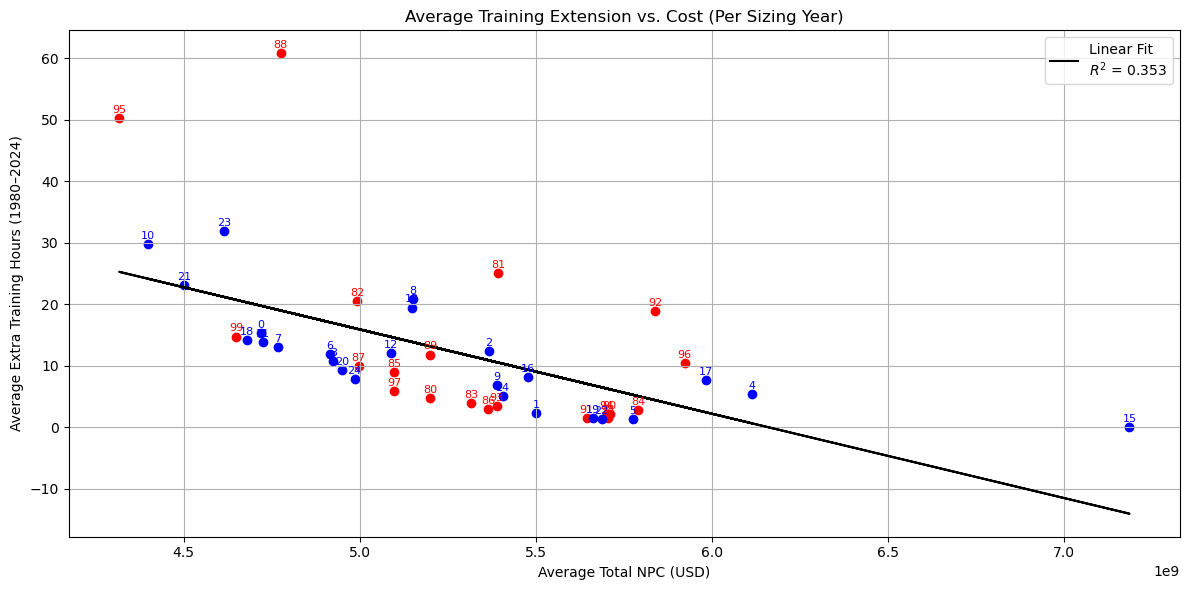

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === Configuration ===
base_path = r"C:\Users\Abdullah"
sizing_years = list(range(2024, 1979, -1))
dispatch_years = list(range(2024, 1979, -1))
folder_pattern = lambda year: (
    os.path.join(base_path, "dispatch_outputs_solar-wind_dc") if year == 2024
    else os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}")
)

# === Storage ===
avg_npc_list = []
avg_training_hours_list = []
valid_years = []

# === Loop over each sizing folder (dcYYYY) ===
for sizing_year in sizing_years:
    folder = folder_pattern(sizing_year)
    cost_file = os.path.join(folder, "capacity_and_costs_by_year.csv")
    
    try:
        # --- Load ALL NPC values for 1980–2024 ---
        df_cost = pd.read_csv(cost_file)
        avg_npc = df_cost['Total_NPC'].mean()

        # --- Sum of extra training hours (always divide by 45) ---
        total_extension_hours = 0
        for dispatch_year in dispatch_years:
            ext_file = os.path.join(folder, f"training_extension_{dispatch_year}.csv")
            if os.path.exists(ext_file):
                df_ext = pd.read_csv(ext_file)
                if 'Extra Training Hours' in df_ext.columns and not df_ext.empty:
                    total_extension_hours += df_ext['Extra Training Hours'].sum()
            # Else: missing file = 0 implicitly

        avg_extension = total_extension_hours / 45  # Always divide by 45 regardless of missing years

        # Store results
        valid_years.append(sizing_year)
        avg_npc_list.append(avg_npc)
        avg_training_hours_list.append(avg_extension)
        print(f"{sizing_year} | Avg NPC: {avg_npc:.2e} | Avg Training Ext: {avg_extension:.2f} hrs")

    except Exception as e:
        print(f"[SKIPPED] {sizing_year} → {e}")

# === Combine and sort ===
df_combined = pd.DataFrame({
    'Year': valid_years,
    'Avg_Total_NPC': avg_npc_list,
    'Avg_Extra_Training_Hours': avg_training_hours_list
}).sort_values('Year')

# === Linear regression ===
slope, intercept, r_value, _, _ = linregress(df_combined['Avg_Total_NPC'], df_combined['Avg_Extra_Training_Hours'])
r2 = r_value**2

# === Plotting ===
plt.figure(figsize=(12, 6))
for _, row in df_combined.iterrows():
    year = int(row['Year'])
    npc = row['Avg_Total_NPC']
    ext = row['Avg_Extra_Training_Hours']
    label = str(year % 100)
    color = 'blue' if year >= 2000 else 'red'
    plt.scatter(npc, ext, color=color)
    plt.text(npc, ext + 0.5, label, ha='center', va='bottom', fontsize=8, color=color)

plt.plot(df_combined['Avg_Total_NPC'],
         slope * df_combined['Avg_Total_NPC'] + intercept,
         color='black', label=f'Linear Fit\n$R^2$ = {r2:.3f}')

plt.xlabel("Average Total NPC (USD)")
plt.ylabel("Average Extra Training Hours (1980–2024)")
plt.title("Average Training Extension vs. Cost (Per Sizing Year)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


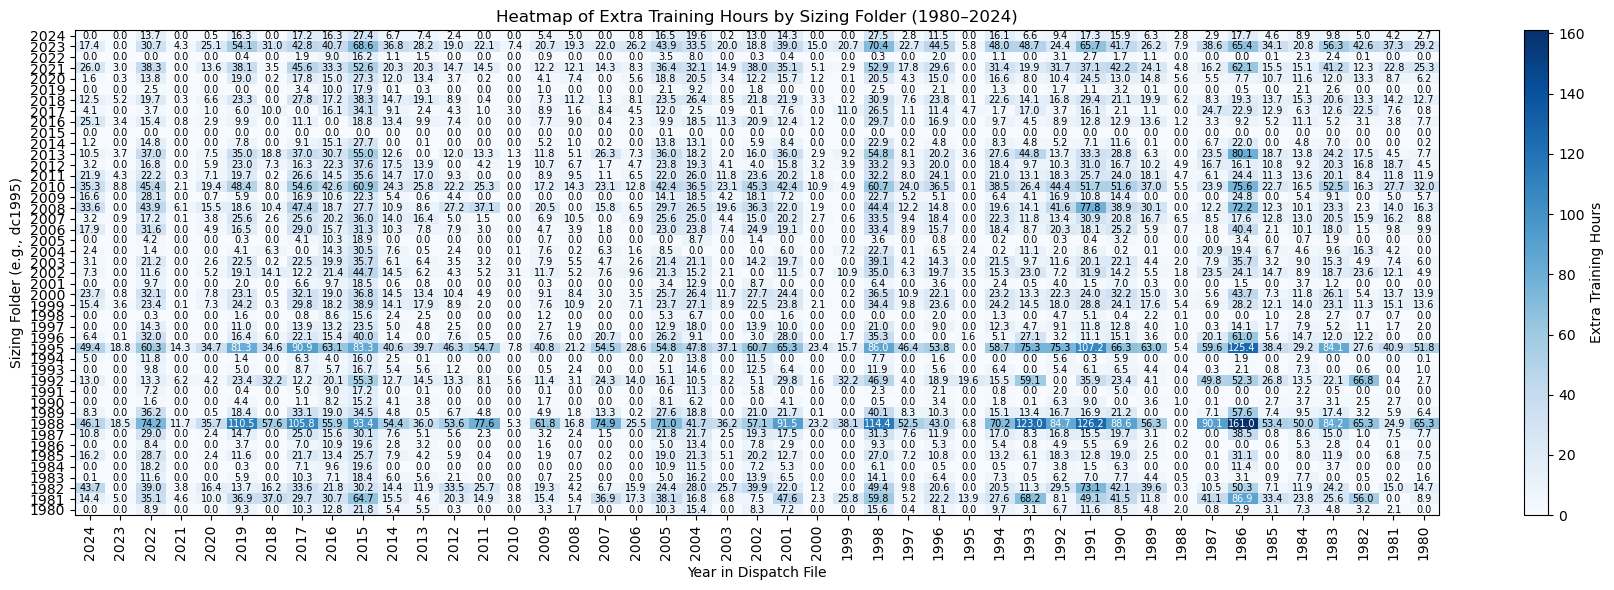


=== AVERAGE EXTENSIONS PER FOLDER ===
2024: 7.89 hours average extra training time
2023: 31.95 hours average extra training time
2022: 1.34 hours average extra training time
2021: 23.05 hours average extra training time
2020: 9.37 hours average extra training time
2019: 1.46 hours average extra training time
2018: 14.16 hours average extra training time
2017: 7.73 hours average extra training time
2016: 8.23 hours average extra training time
2015: 0.00 hours average extra training time
2014: 5.09 hours average extra training time
2013: 19.47 hours average extra training time
2012: 12.09 hours average extra training time
2011: 13.82 hours average extra training time
2010: 29.77 hours average extra training time
2009: 6.87 hours average extra training time
2008: 20.91 hours average extra training time
2007: 13.04 hours average extra training time
2006: 11.85 hours average extra training time
2005: 1.40 hours average extra training time
2004: 5.39 hours average extra training time
2003: 

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# === CONFIGURATION ===
base_path = r"C:\Users\Abdullah"
folders = {
    year: os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}") if year != 2024
    else os.path.join(base_path, "dispatch_outputs_solar-wind_dc")
    for year in range(2024, 1979, -1)
}
years = list(range(2024, 1979, -1))  # Dispatch years to process within each folder

# === INTERPOLATION SETUP ===
power_watts = np.array([250, 225, 200, 175, 150, 125, 100, 50, 0])
training_times = np.array([40000, 42000, 42500, 45000, 46000, 50000, 58000, 70000, 80000])
baseline_time = training_times[0]
extension_factors = training_times / baseline_time
power_missing_fraction = (250 - power_watts) / 250
interpolator = interp1d(power_missing_fraction, extension_factors, kind='cubic', fill_value='extrapolate')

def get_training_extension(power_percent):
    power_percent = np.clip(power_percent, 0, 100)
    missing_fraction = 1 - (power_percent / 100)
    return interpolator(missing_fraction)

# === MAIN PROCESSING ===
heatmap_matrix = []
print_outputs = {}

for folder_label, folder_path in folders.items():
    row_values = []
    yearly_extension_hours = {}

    for year in years:
        file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
        try:
            df = pd.read_csv(file_path)
            unmet_rows = df[df['Unmet (kW)'] > 0].copy()
            if unmet_rows.empty:
                yearly_extension_hours[year] = 0
                row_values.append(0)
                continue

            unmet_rows['Unmet (%)'] = (unmet_rows['Unmet (kW)'] / unmet_rows['Load (kW)']) * 100
            unmet_rows['Power Available (%)'] = 100 - unmet_rows['Unmet (%)']
            unmet_rows['Training Time Extension (×)'] = unmet_rows['Power Available (%)'].apply(get_training_extension)
            unmet_rows['Extra Training Hours'] = unmet_rows['Training Time Extension (×)'] - 1

            # Save per-year CSV
            result = unmet_rows[['Hour', 'Load (kW)', 'Unmet (kW)', 'Unmet (%)',
                                 'Power Available (%)', 'Training Time Extension (×)', 'Extra Training Hours']]
            save_path = os.path.join(folder_path, f"training_extension_{year}.csv")
            result.to_csv(save_path, index=False)

            total_extra = result['Extra Training Hours'].sum()
            yearly_extension_hours[year] = total_extra
            row_values.append(total_extra)

        except FileNotFoundError:
            print(f"[MISSING] {file_path}")
            yearly_extension_hours[year] = None
            row_values.append(0)

    heatmap_matrix.append(row_values)
    print_outputs[folder_label] = yearly_extension_hours

# === HEATMAP PLOTTING ===
plt.figure(figsize=(18, 6))
heatmap_array = np.array(heatmap_matrix)
im = plt.imshow(heatmap_array, cmap='Blues', aspect='auto')

# Contrast helper
def get_text_color(value, vmin, vmax):
    normalized = (value - vmin) / (vmax - vmin + 1e-9)
    return 'white' if normalized > 0.5 else 'black'

vmin, vmax = np.min(heatmap_array), np.max(heatmap_array)

# Add value annotations
for i in range(heatmap_array.shape[0]):
    for j in range(heatmap_array.shape[1]):
        value = heatmap_array[i, j]
        color = get_text_color(value, vmin, vmax)
        plt.text(j, i, f"{value:.1f}", ha='center', va='center', fontsize=7, color=color)

# Axes labels
plt.xticks(ticks=np.arange(len(years)), labels=years, rotation=90)
plt.yticks(ticks=np.arange(len(folders)), labels=[str(k) for k in folders.keys()])
plt.xlabel("Year in Dispatch File")
plt.ylabel("Sizing Folder")
plt.title("Heatmap of Extra Training Hours by Sizing Folder (1980–2024)")
plt.colorbar(im, label="Extra Training Hours")
plt.tight_layout()
plt.show()

# === AVERAGE EXTENSIONS ===
print("\n=== AVERAGE EXTENSIONS PER FOLDER ===")
for label in print_outputs:
    values = [v for v in print_outputs[label].values() if v is not None]
    avg = np.mean(values)
    print(f"{label}: {avg:.2f} hours average extra training time")


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_22880\3013701942.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')


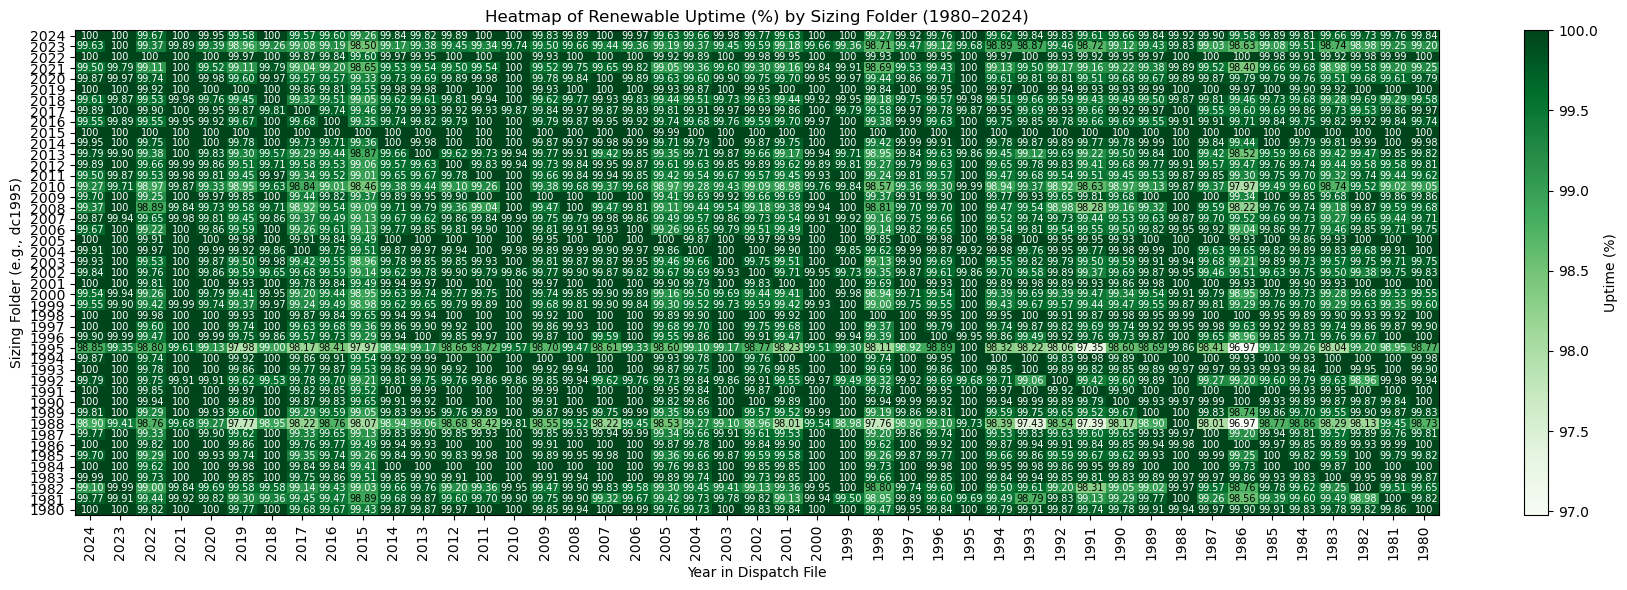

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===
base_path = r"C:\Users\Abdullah"
folders = {
    year: os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}") if year != 2024
    else os.path.join(base_path, "dispatch_outputs_solar-wind_dc")
    for year in range(2024, 1979, -1)
}
years = list(range(2024, 1979, -1))  # Dispatch years to process

# === MAIN PROCESSING ===
uptime_matrix = []

for folder_label, folder_path in folders.items():
    row_values = []

    for year in years:
        file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
        try:
            df = pd.read_csv(file_path)
            unmet_hours = (df['Unmet (kW)'] > 0).sum()
            uptime = 100 * (1 - unmet_hours / 8760)
            row_values.append(uptime)
        except FileNotFoundError:
            row_values.append(np.nan)

    uptime_matrix.append(row_values)

# === HEATMAP PLOTTING ===
plt.figure(figsize=(18, 6))
heatmap_array = np.array(uptime_matrix)
im = plt.imshow(heatmap_array, cmap='Greens', aspect='auto')

# Helper: choose black or white based on cell brightness
def get_text_color_from_cmap(value, cmap, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    r, g, b = rgba[:3]
    brightness = r * 0.299 + g * 0.587 + b * 0.114
    return 'white' if brightness < 0.5 else 'black'

vmin, vmax = np.nanmin(heatmap_array), np.nanmax(heatmap_array)
cmap = plt.cm.get_cmap('Greens')

# Annotate values with contrast-aware text
for i in range(heatmap_array.shape[0]):
    for j in range(heatmap_array.shape[1]):
        value = heatmap_array[i, j]
        if not np.isnan(value):
            color = get_text_color_from_cmap(value, cmap, vmin, vmax)
            formatted = f"{int(value)}" if value == 100 else f"{value:.2f}"
            plt.text(j, i, formatted, ha='center', va='center', fontsize=7, color=color)

# Axes labels
plt.xticks(ticks=np.arange(len(years)), labels=years, rotation=90)
plt.yticks(ticks=np.arange(len(folders)), labels=[str(k) for k in folders.keys()])
plt.xlabel("Year in Dispatch File")
plt.ylabel("Sizing Folder")
plt.title("Heatmap of Renewable Uptime (%) by Sizing Folder (1980–2024)")
plt.colorbar(im, label="Uptime (%)")
plt.tight_layout()
plt.show()


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_17892\2967792363.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')


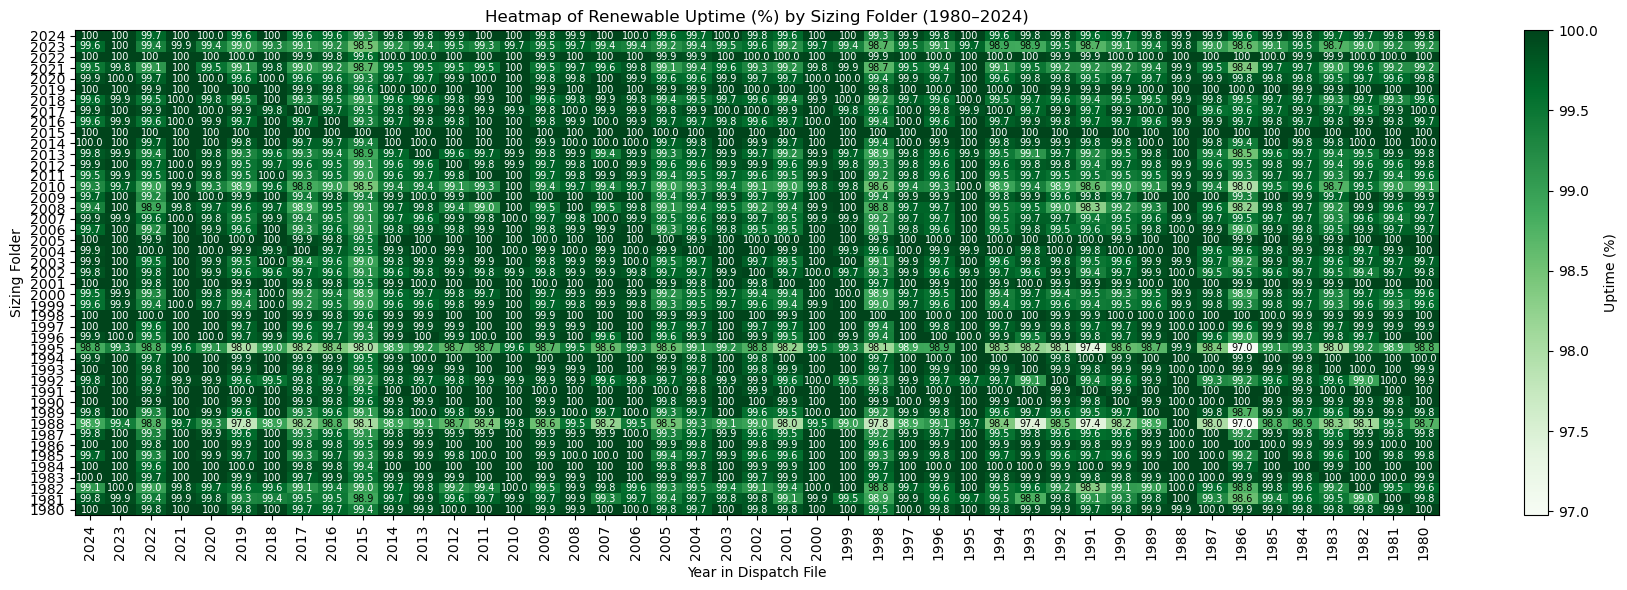

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===
base_path = r"C:\Users\Abdullah"
folders = {
    year: os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}") if year != 2024
    else os.path.join(base_path, "dispatch_outputs_solar-wind_dc")
    for year in range(2024, 1979, -1)
}
years = list(range(2024, 1979, -1))  # Dispatch years to process

# === MAIN PROCESSING ===
uptime_matrix = []

for folder_label, folder_path in folders.items():
    row_values = []

    for year in years:
        file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
        try:
            df = pd.read_csv(file_path)
            unmet_hours = (df['Unmet (kW)'] > 0).sum()
            uptime = 100 * (1 - unmet_hours / 8760)
            row_values.append(uptime)
        except FileNotFoundError:
            row_values.append(np.nan)

    uptime_matrix.append(row_values)

# === HEATMAP PLOTTING ===
plt.figure(figsize=(18, 6))
heatmap_array = np.array(uptime_matrix)
im = plt.imshow(heatmap_array, cmap='Greens', aspect='auto')

# Helper: choose black or white based on cell brightness
def get_text_color_from_cmap(value, cmap, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(value))
    r, g, b = rgba[:3]
    brightness = r * 0.299 + g * 0.587 + b * 0.114
    return 'white' if brightness < 0.5 else 'black'

vmin, vmax = np.nanmin(heatmap_array), np.nanmax(heatmap_array)
cmap = plt.cm.get_cmap('Greens')

# Annotate values with contrast-aware text
for i in range(heatmap_array.shape[0]):
    for j in range(heatmap_array.shape[1]):
        value = heatmap_array[i, j]
        if not np.isnan(value):
            color = get_text_color_from_cmap(value, cmap, vmin, vmax)
            formatted = f"{int(value)}" if value == 100 else f"{value:.1f}"
            plt.text(j, i, formatted, ha='center', va='center', fontsize=7, color=color)

# Axes labels
plt.xticks(ticks=np.arange(len(years)), labels=years, rotation=90)
plt.yticks(ticks=np.arange(len(folders)), labels=[str(k) for k in folders.keys()])
plt.xlabel("Year in Dispatch File")
plt.ylabel("Sizing Folder")
plt.title("Heatmap of Renewable Uptime (%) by Sizing Folder (1980–2024)")
plt.colorbar(im, label="Uptime (%)")
plt.tight_layout()
plt.show()


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_22880\1450284282.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


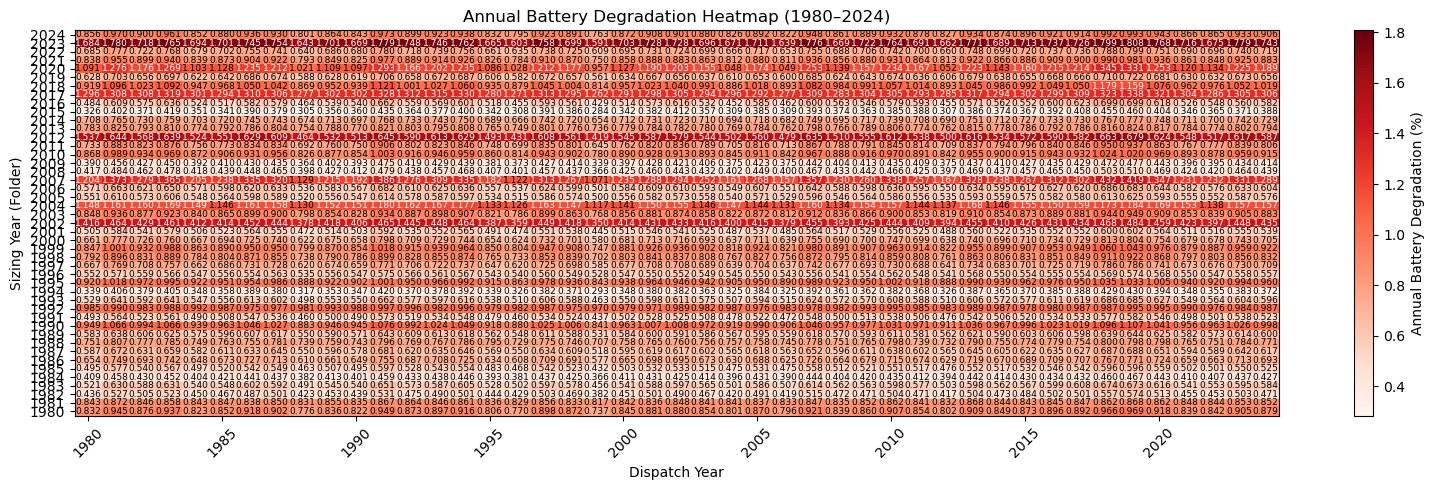

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===
base_path = r"C:\Users\Abdullah"
folders = {
    year: os.path.join(base_path, f"dispatch_outputs_solar-wind_dc{year}") if year != 2024
    else os.path.join(base_path, "dispatch_outputs_solar-wind_dc")
    for year in range(2024, 1979, -1)
}
years = list(range(1980, 2025))   # Dispatch years
sizings = list(range(2024, 1979, -1))  # Sizing folders (rows)

# === BUILD 2D DEGRADATION MATRIX ===
degradation_matrix = []

for sizing_year in sizings:
    folder = folders[sizing_year]
    row = []
    for dispatch_year in years:
        try:
            file_path = os.path.join(folder, f"cycles_{dispatch_year}.csv")
            df = pd.read_csv(file_path)
            total_deg = df["degradation"].sum()
            row.append(total_deg * 100)  # convert to %
        except Exception as e:
            print(f"{sizing_year} → {dispatch_year}: {e}")
            row.append(np.nan)
    degradation_matrix.append(row)

degradation_matrix = np.array(degradation_matrix)

# === PLOT HEATMAP ===
fig, ax = plt.subplots(figsize=(16, 5))
im = ax.imshow(degradation_matrix, aspect='auto', cmap='Reds', interpolation='nearest')
cbar = plt.colorbar(im, ax=ax, label='Annual Battery Degradation (%)')
ax.set_title('Annual Battery Degradation Heatmap (1980–2024)')
ax.set_xlabel('Dispatch Year')
ax.set_ylabel('Sizing Year (Folder)')

# === X/Y ticks ===
ax.set_xticks(np.arange(len(years))[::5])
ax.set_xticklabels(years[::5], rotation=45)
ax.set_yticks(np.arange(len(sizings)))
ax.set_yticklabels(sizings)

# === Annotate each cell with conditional formatting ===
norm = plt.Normalize(vmin=np.nanmin(degradation_matrix), vmax=np.nanmax(degradation_matrix))
cmap = plt.cm.get_cmap('Reds')

for i in range(degradation_matrix.shape[0]):
    for j in range(degradation_matrix.shape[1]):
        val = degradation_matrix[i, j]
        if not np.isnan(val):
            rgb = cmap(norm(val))[:3]
            brightness = np.dot(rgb, [0.299, 0.587, 0.114])
            text_color = 'black' if brightness > 0.5 else 'white'
            formatted = f"{int(val)}" if val == 100 else f"{val:.3f}"
            ax.text(j, i, formatted, ha='center', va='center', fontsize=6.5, color=text_color)

# === Save & Show ===
plt.tight_layout()
plt.savefig(r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc\degradation_heatmap.png", dpi=300)
plt.show()
